# Go from RA, Dec to Detector X,Y

This notebook shows how to go from an input (ra, dec) on the sky to identify the detector and (x, y) position on that detector given the boresight and rotation of the camera.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lsst.geom
import lsst.obs.lsst as obs_lsst
import lsst.obs.lsst.phosim as obs_phosim
from lsst.obs.base import createInitialSkyWcsFromBoresight
%matplotlib inline

In [9]:
# Code from Robert Lupton
from lsst.afw.cameraGeom import FIELD_ANGLE, FOCAL_PLANE, PIXELS

def findDetectorAndXY(ra, dec, orientation, boresight, camera, flipX=False, det0Name='R22_S11'):
    """
    Find the location of a given (ra, dec) in the focal plane 
    Parameters
    ----------
    ra : `float`
       right ascension in degrees
    dec : `float`
       declination in degrees
    orientation : `lsst.geom.Angle`
       Rotation of the focal plane
    boresight: lsst.geom.SpherePoint`
       Telescope boresight
    flipX : `bool`
       Flip the Wcs in x
    det0Name : `str`
       The name of the detector we should use to build the initial WCS
    """
    # build a WCS from the boresight and rotation
    det0 = camera[det0Name]   # a CCD near the centre of the focal plane
    wcs0 = createInitialSkyWcsFromBoresight(boresight, orientation, det0, flipX)
    #
    # Map (ra, dec) to mm in the focal plane
    raDec = lsst.geom.SpherePoint(ra*lsst.geom.degrees, dec*lsst.geom.degrees)
    xy0 = wcs0.skyToPixel(raDec)   # pixel coords based on wcs0
    xy_mm = det0.transform(xy0, PIXELS, FOCAL_PLANE)  # mm
    #
    # Look up which CCD that position lies on
    detList = camera.findDetectors(xy_mm, FOCAL_PLANE)
    if len(detList) == 0:
        raise RuntimeError(r"Position (%.3f, %.3f)mm in focal plane does not lie on a CCD" % (xy_mm[0], xy_mm[1]))
    elif len(detList) > 1:
        raise RuntimeError(r"Position (%.3f, %.3f)mm in focal plane appears to lie on more than one CCD?!?" % (xy_mm[0], xy_mm[1]))
    det = detList[0]   # detector which correspond to that point
    #
    # Get the xy position within that detector
    xy = det.transform(xy_mm, FOCAL_PLANE, PIXELS)  # pixels on det
    
    return det, xy

## Compare results on Gaia Low Latitude data

Here we take a set of donuts where we used the Gaia catalog as input to phosim and we then identified the donut locations on the resulting phosim images.
Then we used the phosim header information to create an initial WCS. We used this WCS as an initial guess for the DM cross-matching code to match our sources to the Gaia catalog we used as input.
Finally we save the (ra, dec) from this match and the (detector, X, Y) information. We will use this to compare the output from the code above where we generate a WCS solely from the boresight and telescope rotation information.

### Load Gaia match data from Phosim images

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('/astro/users/brycek/epyc/users/brycek/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/image_donut_df.csv', index_col=0)

In [5]:
df

,id,coord_ra,coord_dec,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,phot_g_mean_fluxErr,phot_bp_mean_fluxErr,phot_rp_mean_fluxErr,coord_raErr,...,blended,blended_with,num_blended_neighbors,mag,ra,dec,raft,sensor,x_center,y_center
0,4113677143086208256,4.482027,-0.405154,2.388609e+08,1.992512e+08,2.750225e+08,1.344580e+05,206252.477936,1.785561e+05,2.209610e-10,...,True,"[33, 594, 667, 1013, 1091, 1233, 1714, 1782, 1...",74,10.454637,256.801252,-23.213628,R22,S02,1338.677951,1111.424346
1,4113676726444534784,4.481707,-0.405513,1.541969e+08,2.468465e+07,4.152637e+08,1.062888e+06,800266.550294,6.714116e+06,4.713170e-10,...,True,"[92, 148, 660, 681, 916, 979, 1015, 1215, 1256...",92,10.929811,256.782915,-23.234203,R22,S02,967.848173,809.118408
2,4113675081501630208,4.481042,-0.406290,8.540896e+07,4.662908e+07,1.422795e+08,6.928834e+04,74841.523073,1.252699e+05,2.316579e-10,...,True,"[285, 387, 659, 1200, 1528, 1546, 1786, 1955, ...",81,11.571241,256.744799,-23.278687,R22,S02,166.041434,181.394381
3,4113673088636284544,4.483761,-0.406186,6.208514e+07,2.536215e+07,1.233092e+08,1.786180e+04,58165.418760,1.618449e+05,2.249665e-10,...,True,"[96, 214, 392, 416, 493, 729, 1650, 1725, 1959...",82,11.917531,256.900553,-23.272733,R22,S02,278.347398,2755.353623
4,4113677280524482816,4.482369,-0.404893,4.683642e+07,2.487201e+07,8.066949e+07,8.922057e+03,45520.723194,1.029016e+05,2.519979e-10,...,True,"[484, 580, 605, 680, 810, 1134, 1727, 1933, 26...",75,12.223541,256.820824,-23.198668,R22,S02,1608.477965,1434.500836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,4112891812578012672,4.491733,-0.412718,1.238132e+07,8.624611e+06,1.741094e+07,2.953387e+03,14622.605713,1.642939e+04,1.311986e-10,...,True,"[576, 583, 845, 1002, 1133, 1639, 1742, 2266, ...",104,13.668083,257.357372,-23.646988,R22,S20,1994.572216,1845.166203
204,4112885215507938816,4.490197,-0.413968,1.119187e+07,5.372036e+06,2.062271e+07,3.471654e+03,8004.853803,1.928612e+04,1.437682e-10,...,True,"[994, 1147, 1307, 1464, 1875, 2663, 2972, 2986...",105,13.777744,257.269314,-23.718635,R22,S20,707.643558,391.727718
205,4112897554995016704,4.490888,-0.413022,7.666582e+06,4.299964e+06,1.295849e+07,2.367830e+03,7011.087084,1.209880e+04,1.425563e-10,...,True,"[679, 1074, 1438, 1560, 1573, 1590, 1604, 2038...",119,14.188496,257.308921,-23.664419,R22,S20,1682.373240,1045.923882
206,4112891335882207744,4.493774,-0.412608,5.245761e+06,2.400220e+06,9.972960e+06,1.700206e+03,4157.776817,9.218889e+03,1.535421e-10,...,True,"[1078, 1158, 1809, 1815, 1845, 1886, 2152, 223...",105,14.600479,257.474310,-23.640680,R22,S20,2103.466891,3772.638585


### Set up telescope pointing information

In [6]:
boresight_ra = 257.11044958320826
boresight_dec = -23.409732178640596
boresight_pointing = lsst.geom.SpherePoint(boresight_ra, boresight_dec, lsst.geom.degrees)
tel_rot = 0.

### Set up camera objects from `obs_lsst`

We will set up a camera with the `LSSTCamMapper` as well as a `PhosimMapper` to compare the results

In [7]:
lsst_cam_mapper = obs_lsst.lsstCamMapper.LsstCamMapper()
lsst_camera = lsst_cam_mapper.camera

phosim_cam_mapper = obs_phosim.PhosimMapper()
phosim_camera = phosim_cam_mapper.camera

### Results with LSST camera. Both rotations at 0.

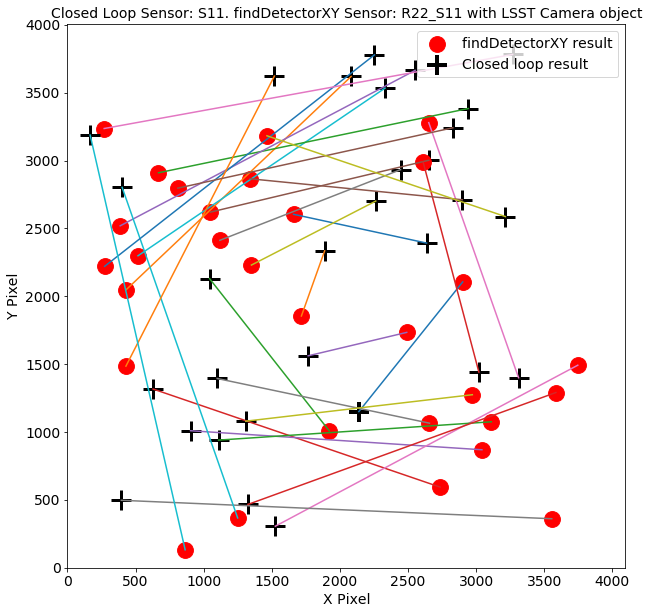

In [18]:
fig = plt.figure(figsize=(10,10))
sensor_name = "S11"
sensor_df = df.query('sensor == "%s"' % sensor_name)
legend_set = False
for row_idx, test_obj in sensor_df.iterrows():
    detector, point_xy = findDetectorAndXY(test_obj['ra'], test_obj['dec'], tel_rot*lsst.geom.degrees, boresight_pointing, lsst_camera, flipX=False)
    if legend_set is False:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250, label='findDetectorXY result')
        plt.scatter(test_obj['x_center'], test_obj['y_center'], c='k', marker='+', lw=4, s=400, label='Closed loop result')
        legend_set = True
    else:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250)
        plt.scatter(test_obj['x_center'], test_obj['y_center'], c='k', s=400, marker='+', lw=3, )
    plt.plot([point_xy[0], test_obj['x_center']], [point_xy[1], test_obj['y_center']])
plt.xlim(0, 4096)
plt.ylim(0, 4004)
plt.xlabel('X Pixel', size=14)
plt.ylabel('Y Pixel', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Closed Loop Sensor: {}. findDetectorXY Sensor: {} with LSST Camera object'.format(sensor_name, detector.getName()), size=14)
plt.legend(fontsize=14)

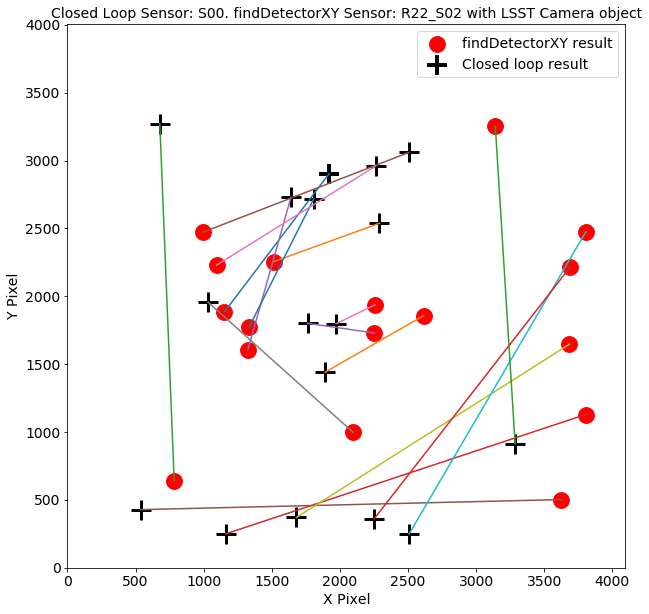

In [19]:
fig = plt.figure(figsize=(10,10))
sensor_name = "S00"
sensor_df = df.query('sensor == "%s"' % sensor_name)
legend_set = False
for row_idx, test_obj in sensor_df.iterrows():
    detector, point_xy = findDetectorAndXY(test_obj['ra'], test_obj['dec'], tel_rot*lsst.geom.degrees, boresight_pointing, lsst_camera, flipX=False)
    if legend_set is False:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250, label='findDetectorXY result')
        plt.scatter(test_obj['x_center'], test_obj['y_center'], c='k', marker='+', lw=4, s=400, label='Closed loop result')
        legend_set = True
    else:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250)
        plt.scatter(test_obj['x_center'], test_obj['y_center'], c='k', s=400, marker='+', lw=3, )
    plt.plot([point_xy[0], test_obj['x_center']], [point_xy[1], test_obj['y_center']])
plt.xlim(0, 4096)
plt.ylim(0, 4004)
plt.xlabel('X Pixel', size=14)
plt.ylabel('Y Pixel', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Closed Loop Sensor: {}. findDetectorXY Sensor: {} with LSST Camera object'.format(sensor_name, detector.getName()), size=14)
plt.legend(fontsize=14)

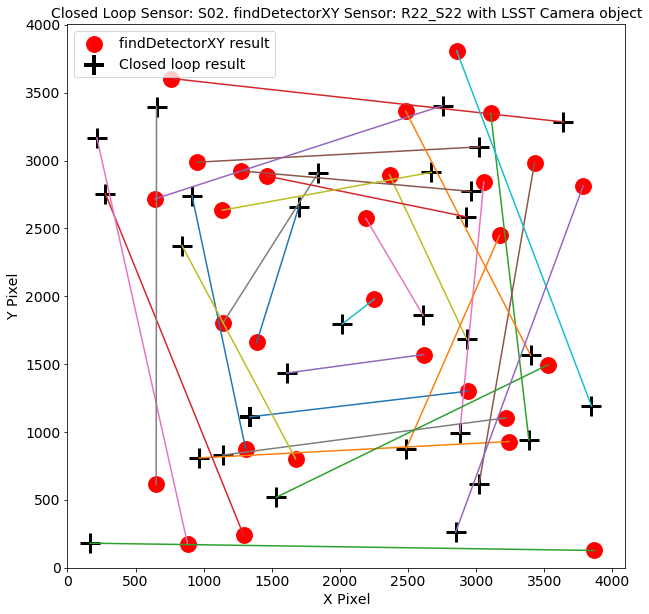

In [20]:
fig = plt.figure(figsize=(10,10))
sensor_name = "S02"
sensor_df = df.query('sensor == "%s"' % sensor_name)
legend_set = False
for row_idx, test_obj in sensor_df.iterrows():
    detector, point_xy = findDetectorAndXY(test_obj['ra'], test_obj['dec'], tel_rot*lsst.geom.degrees, boresight_pointing, lsst_camera, flipX=False)
    if legend_set is False:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250, label='findDetectorXY result')
        plt.scatter(test_obj['x_center'], test_obj['y_center'], c='k', marker='+', lw=4, s=400, label='Closed loop result')
        legend_set = True
    else:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250)
        plt.scatter(test_obj['x_center'], test_obj['y_center'], c='k', s=400, marker='+', lw=3, )
    plt.plot([point_xy[0], test_obj['x_center']], [point_xy[1], test_obj['y_center']])
plt.xlim(0, 4096)
plt.ylim(0, 4004)
plt.xlabel('X Pixel', size=14)
plt.ylabel('Y Pixel', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Closed Loop Sensor: {}. findDetectorXY Sensor: {} with LSST Camera object'.format(sensor_name, detector.getName()), size=14)
plt.legend(fontsize=14)

### Results with LSST camera. Rotate camera 90 degrees from phosim rotation.

In [21]:
tel_rot = 90

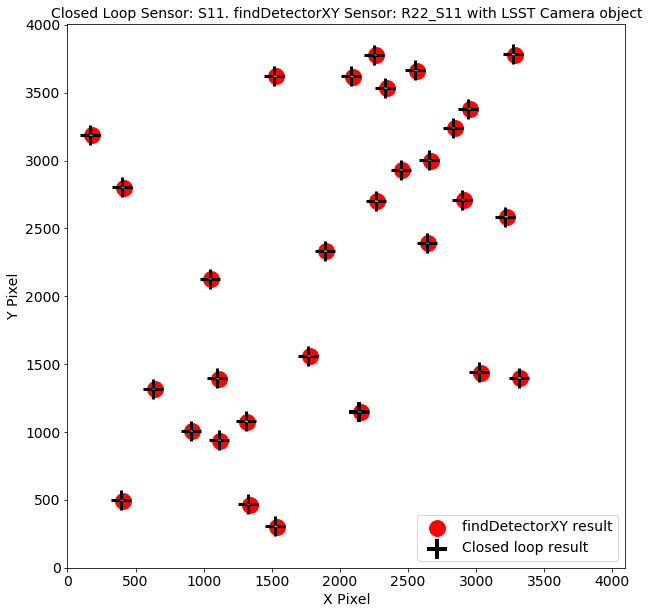

In [22]:
fig = plt.figure(figsize=(10,10))
sensor_name = "S11"
sensor_df = df.query('sensor == "%s"' % sensor_name)
legend_set = False
for row_idx, test_obj in sensor_df.iterrows():
    detector, point_xy = findDetectorAndXY(test_obj['ra'], test_obj['dec'], tel_rot*lsst.geom.degrees, boresight_pointing, lsst_camera, flipX=False)
    if legend_set is False:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250, label='findDetectorXY result')
        plt.scatter(test_obj['x_center'], test_obj['y_center'], c='k', marker='+', lw=4, s=400, label='Closed loop result')
        legend_set = True
    else:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250)
        plt.scatter(test_obj['x_center'], test_obj['y_center'], c='k', s=400, marker='+', lw=3, )
    plt.plot([point_xy[0], test_obj['x_center']], [point_xy[1], test_obj['y_center']])
plt.xlim(0, 4096)
plt.ylim(0, 4004)
plt.xlabel('X Pixel', size=14)
plt.ylabel('Y Pixel', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Closed Loop Sensor: {}. findDetectorXY Sensor: {} with LSST Camera object'.format(sensor_name, detector.getName()), size=14)
plt.legend(fontsize=14)

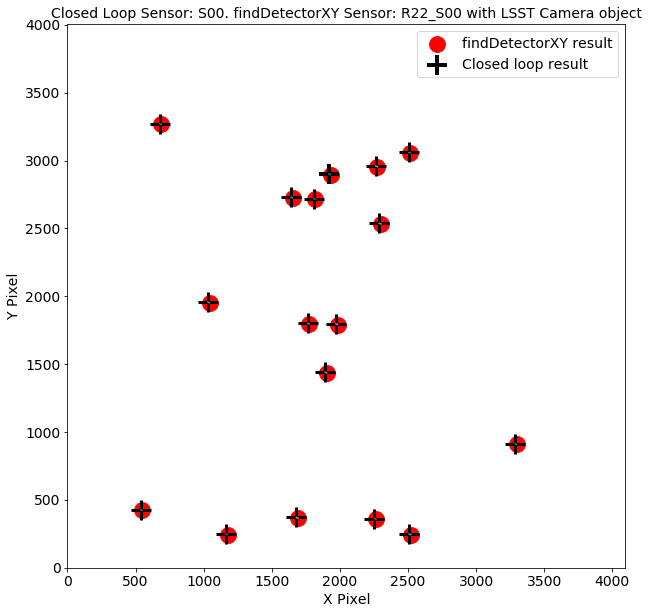

In [24]:
fig = plt.figure(figsize=(10,10))
sensor_name = "S00"
sensor_df = df.query('sensor == "%s"' % sensor_name)
legend_set = False
for row_idx, test_obj in sensor_df.iterrows():
    detector, point_xy = findDetectorAndXY(test_obj['ra'], test_obj['dec'], tel_rot*lsst.geom.degrees, boresight_pointing, lsst_camera, flipX=False)
    if legend_set is False:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250, label='findDetectorXY result')
        plt.scatter(test_obj['x_center'], test_obj['y_center'], c='k', marker='+', lw=4, s=400, label='Closed loop result')
        legend_set = True
    else:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250)
        plt.scatter(test_obj['x_center'], test_obj['y_center'], c='k', s=400, marker='+', lw=3, )
    plt.plot([point_xy[0], test_obj['x_center']], [point_xy[1], test_obj['y_center']])
plt.xlim(0, 4096)
plt.ylim(0, 4004)
plt.xlabel('X Pixel', size=14)
plt.ylabel('Y Pixel', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Closed Loop Sensor: {}. findDetectorXY Sensor: {} with LSST Camera object'.format(sensor_name, detector.getName()), size=14)
plt.legend(fontsize=14)

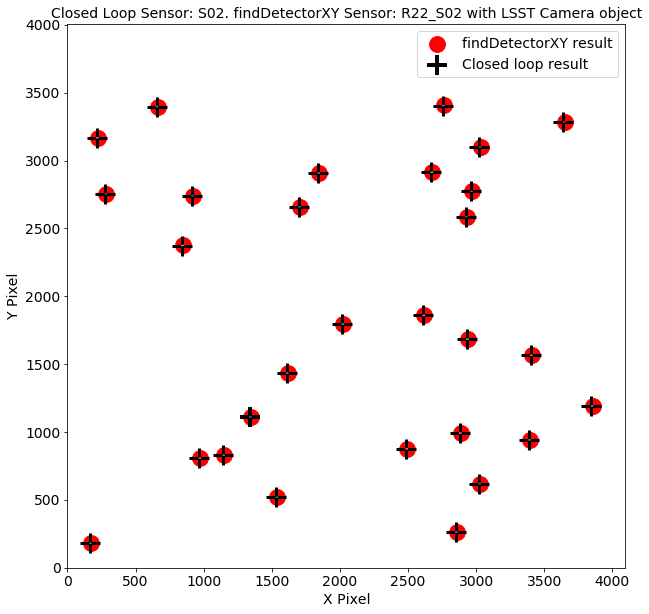

In [25]:
fig = plt.figure(figsize=(10,10))
sensor_name = "S02"
sensor_df = df.query('sensor == "%s"' % sensor_name)
legend_set = False
for row_idx, test_obj in sensor_df.iterrows():
    detector, point_xy = findDetectorAndXY(test_obj['ra'], test_obj['dec'], tel_rot*lsst.geom.degrees, boresight_pointing, lsst_camera, flipX=False)
    if legend_set is False:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250, label='findDetectorXY result')
        plt.scatter(test_obj['x_center'], test_obj['y_center'], c='k', marker='+', lw=4, s=400, label='Closed loop result')
        legend_set = True
    else:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250)
        plt.scatter(test_obj['x_center'], test_obj['y_center'], c='k', s=400, marker='+', lw=3, )
    plt.plot([point_xy[0], test_obj['x_center']], [point_xy[1], test_obj['y_center']])
plt.xlim(0, 4096)
plt.ylim(0, 4004)
plt.xlabel('X Pixel', size=14)
plt.ylabel('Y Pixel', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Closed Loop Sensor: {}. findDetectorXY Sensor: {} with LSST Camera object'.format(sensor_name, detector.getName()), size=14)
plt.legend(fontsize=14)

### Compare to PhosimMapper with same 90-degree rotation

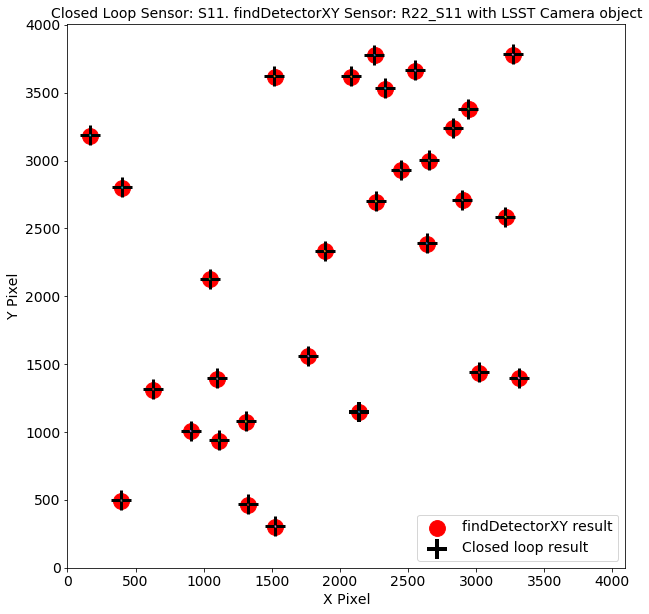

In [26]:
fig = plt.figure(figsize=(10,10))
sensor_name = "S11"
sensor_df = df.query('sensor == "%s"' % sensor_name)
legend_set = False
for row_idx, test_obj in sensor_df.iterrows():
    detector, point_xy = findDetectorAndXY(test_obj['ra'], test_obj['dec'], tel_rot*lsst.geom.degrees, boresight_pointing, phosim_camera, flipX=False)
    if legend_set is False:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250, label='findDetectorXY result')
        plt.scatter(test_obj['x_center'], test_obj['y_center'], c='k', marker='+', lw=4, s=400, label='Closed loop result')
        legend_set = True
    else:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250)
        plt.scatter(test_obj['x_center'], test_obj['y_center'], c='k', s=400, marker='+', lw=3, )
    plt.plot([point_xy[0], test_obj['x_center']], [point_xy[1], test_obj['y_center']])
plt.xlim(0, 4096)
plt.ylim(0, 4004)
plt.xlabel('X Pixel', size=14)
plt.ylabel('Y Pixel', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Closed Loop Sensor: {}. findDetectorXY Sensor: {} with LSST Camera object'.format(sensor_name, detector.getName()), size=14)
plt.legend(fontsize=14)

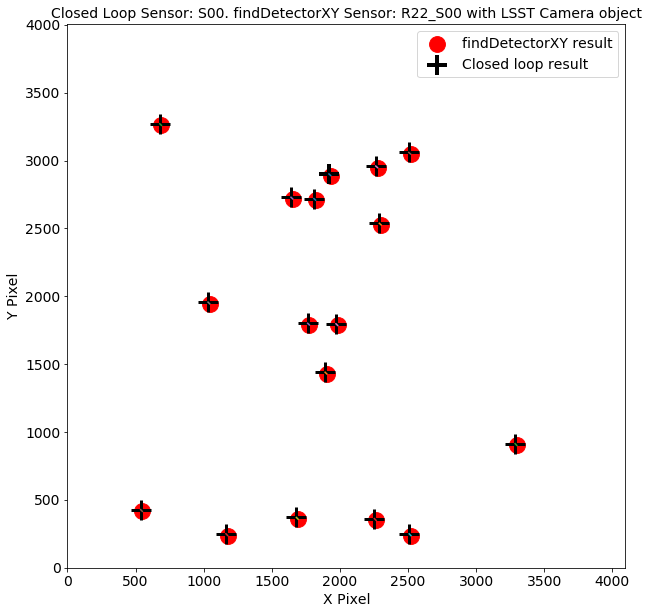

In [27]:
fig = plt.figure(figsize=(10,10))
sensor_name = "S00"
sensor_df = df.query('sensor == "%s"' % sensor_name)
legend_set = False
for row_idx, test_obj in sensor_df.iterrows():
    detector, point_xy = findDetectorAndXY(test_obj['ra'], test_obj['dec'], tel_rot*lsst.geom.degrees, boresight_pointing, phosim_camera, flipX=False)
    if legend_set is False:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250, label='findDetectorXY result')
        plt.scatter(test_obj['x_center'], test_obj['y_center'], c='k', marker='+', lw=4, s=400, label='Closed loop result')
        legend_set = True
    else:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250)
        plt.scatter(test_obj['x_center'], test_obj['y_center'], c='k', s=400, marker='+', lw=3, )
    plt.plot([point_xy[0], test_obj['x_center']], [point_xy[1], test_obj['y_center']])
plt.xlim(0, 4096)
plt.ylim(0, 4004)
plt.xlabel('X Pixel', size=14)
plt.ylabel('Y Pixel', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Closed Loop Sensor: {}. findDetectorXY Sensor: {} with LSST Camera object'.format(sensor_name, detector.getName()), size=14)
plt.legend(fontsize=14)

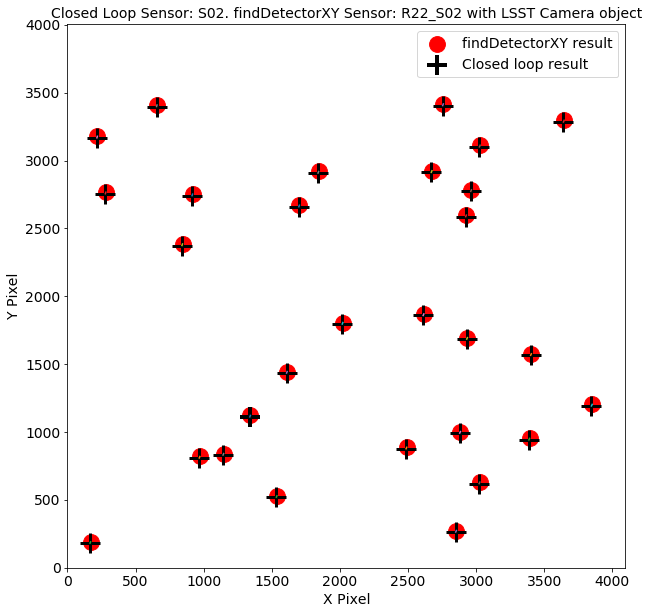

In [28]:
fig = plt.figure(figsize=(10,10))
sensor_name = "S02"
sensor_df = df.query('sensor == "%s"' % sensor_name)
legend_set = False
for row_idx, test_obj in sensor_df.iterrows():
    detector, point_xy = findDetectorAndXY(test_obj['ra'], test_obj['dec'], tel_rot*lsst.geom.degrees, boresight_pointing, phosim_camera, flipX=False)
    if legend_set is False:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250, label='findDetectorXY result')
        plt.scatter(test_obj['x_center'], test_obj['y_center'], c='k', marker='+', lw=4, s=400, label='Closed loop result')
        legend_set = True
    else:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250)
        plt.scatter(test_obj['x_center'], test_obj['y_center'], c='k', s=400, marker='+', lw=3, )
    plt.plot([point_xy[0], test_obj['x_center']], [point_xy[1], test_obj['y_center']])
plt.xlim(0, 4096)
plt.ylim(0, 4004)
plt.xlabel('X Pixel', size=14)
plt.ylabel('Y Pixel', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Closed Loop Sensor: {}. findDetectorXY Sensor: {} with LSST Camera object'.format(sensor_name, detector.getName()), size=14)
plt.legend(fontsize=14)

### Compare to LSST camera with `flipX=True`. LSST Camera rotation back to same as Phosim

In [30]:
tel_rot = 0

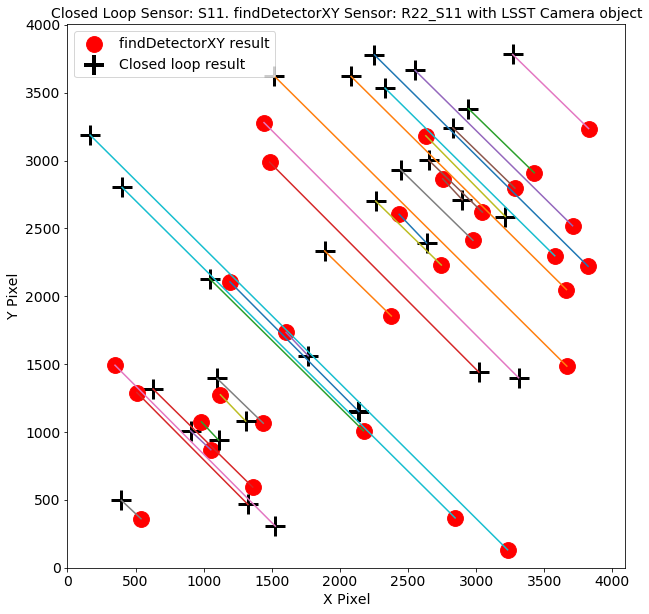

In [31]:
fig = plt.figure(figsize=(10,10))
sensor_name = "S11"
sensor_df = df.query('sensor == "%s"' % sensor_name)
legend_set = False
for row_idx, test_obj in sensor_df.iterrows():
    detector, point_xy = findDetectorAndXY(test_obj['ra'], test_obj['dec'], tel_rot*lsst.geom.degrees, boresight_pointing, lsst_camera, flipX=True)
    if legend_set is False:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250, label='findDetectorXY result')
        plt.scatter(test_obj['x_center'], test_obj['y_center'], c='k', marker='+', lw=4, s=400, label='Closed loop result')
        legend_set = True
    else:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250)
        plt.scatter(test_obj['x_center'], test_obj['y_center'], c='k', s=400, marker='+', lw=3, )
    plt.plot([point_xy[0], test_obj['x_center']], [point_xy[1], test_obj['y_center']])
plt.xlim(0, 4096)
plt.ylim(0, 4004)
plt.xlabel('X Pixel', size=14)
plt.ylabel('Y Pixel', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Closed Loop Sensor: {}. findDetectorXY Sensor: {} with LSST Camera object'.format(sensor_name, detector.getName()), size=14)
plt.legend(fontsize=14)

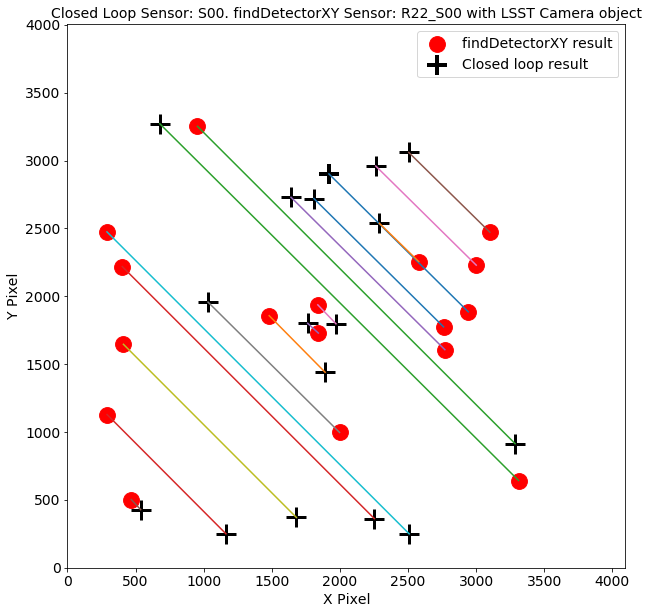

In [34]:
fig = plt.figure(figsize=(10,10))
sensor_name = "S00"
sensor_df = df.query('sensor == "%s"' % sensor_name)
legend_set = False
for row_idx, test_obj in sensor_df.iterrows():
    detector, point_xy = findDetectorAndXY(test_obj['ra'], test_obj['dec'], tel_rot*lsst.geom.degrees, boresight_pointing, lsst_camera, flipX=True)
    if legend_set is False:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250, label='findDetectorXY result')
        plt.scatter(test_obj['x_center'], test_obj['y_center'], c='k', marker='+', lw=4, s=400, label='Closed loop result')
        legend_set = True
    else:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250)
        plt.scatter(test_obj['x_center'], test_obj['y_center'], c='k', s=400, marker='+', lw=3, )
    plt.plot([point_xy[0], test_obj['x_center']], [point_xy[1], test_obj['y_center']])
plt.xlim(0, 4096)
plt.ylim(0, 4004)
plt.xlabel('X Pixel', size=14)
plt.ylabel('Y Pixel', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Closed Loop Sensor: {}. findDetectorXY Sensor: {} with LSST Camera object'.format(sensor_name, detector.getName()), size=14)
plt.legend(fontsize=14)

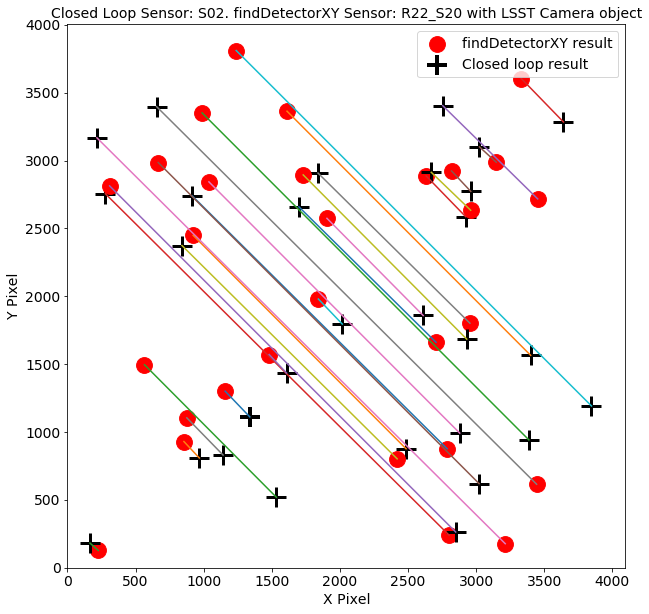

In [35]:
fig = plt.figure(figsize=(10,10))
sensor_name = "S02"
sensor_df = df.query('sensor == "%s"' % sensor_name)
legend_set = False
for row_idx, test_obj in sensor_df.iterrows():
    detector, point_xy = findDetectorAndXY(test_obj['ra'], test_obj['dec'], tel_rot*lsst.geom.degrees, boresight_pointing, lsst_camera, flipX=True)
    if legend_set is False:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250, label='findDetectorXY result')
        plt.scatter(test_obj['x_center'], test_obj['y_center'], c='k', marker='+', lw=4, s=400, label='Closed loop result')
        legend_set = True
    else:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250)
        plt.scatter(test_obj['x_center'], test_obj['y_center'], c='k', s=400, marker='+', lw=3, )
    plt.plot([point_xy[0], test_obj['x_center']], [point_xy[1], test_obj['y_center']])
plt.xlim(0, 4096)
plt.ylim(0, 4004)
plt.xlabel('X Pixel', size=14)
plt.ylabel('Y Pixel', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Closed Loop Sensor: {}. findDetectorXY Sensor: {} with LSST Camera object'.format(sensor_name, detector.getName()), size=14)
plt.legend(fontsize=14)

### Compare to LSST camera with `flipX=True`. LSST Camera Rotation same as phosim. Transpose phosim XY results.

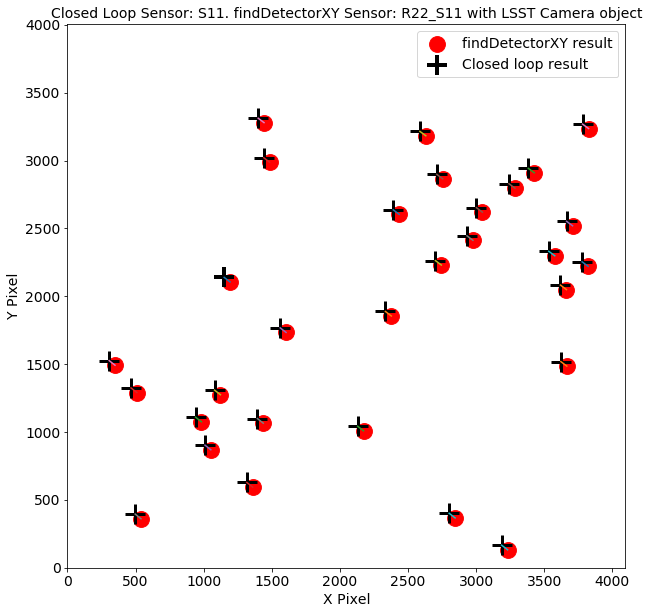

In [36]:
fig = plt.figure(figsize=(10,10))
sensor_name = "S11"
sensor_df = df.query('sensor == "%s"' % sensor_name)
legend_set = False
for row_idx, test_obj in sensor_df.iterrows():
    detector, point_xy = findDetectorAndXY(test_obj['ra'], test_obj['dec'], tel_rot*lsst.geom.degrees, boresight_pointing, lsst_camera, flipX=True)
    if legend_set is False:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250, label='findDetectorXY result')
        plt.scatter(test_obj['y_center'], test_obj['x_center'], c='k', marker='+', lw=4, s=400, label='Closed loop result')
        legend_set = True
    else:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250)
        plt.scatter(test_obj['y_center'], test_obj['x_center'], c='k', s=400, marker='+', lw=3, )
    plt.plot([point_xy[0], test_obj['y_center']], [point_xy[1], test_obj['x_center']])
plt.xlim(0, 4096)
plt.ylim(0, 4004)
plt.xlabel('X Pixel', size=14)
plt.ylabel('Y Pixel', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Closed Loop Sensor: {}. findDetectorXY Sensor: {} with LSST Camera object'.format(sensor_name, detector.getName()), size=14)
plt.legend(fontsize=14)

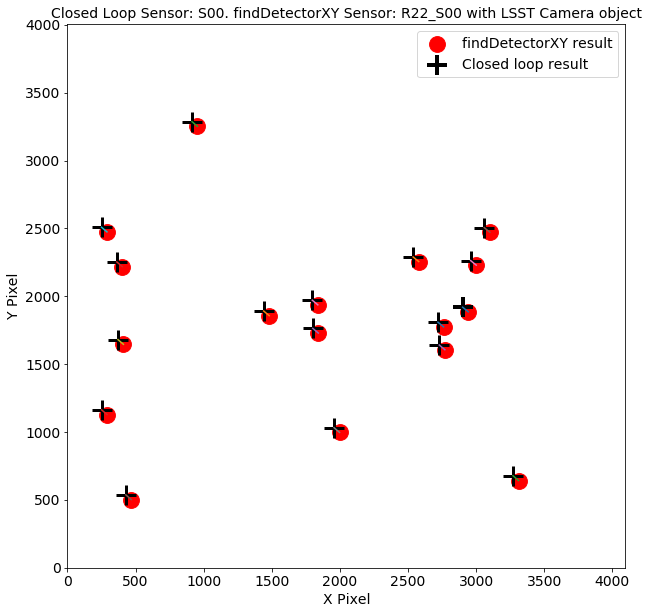

In [37]:
fig = plt.figure(figsize=(10,10))
sensor_name = "S00"
sensor_df = df.query('sensor == "%s"' % sensor_name)
legend_set = False
for row_idx, test_obj in sensor_df.iterrows():
    detector, point_xy = findDetectorAndXY(test_obj['ra'], test_obj['dec'], tel_rot*lsst.geom.degrees, boresight_pointing, lsst_camera, flipX=True)
    if legend_set is False:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250, label='findDetectorXY result')
        plt.scatter(test_obj['y_center'], test_obj['x_center'], c='k', marker='+', lw=4, s=400, label='Closed loop result')
        legend_set = True
    else:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250)
        plt.scatter(test_obj['y_center'], test_obj['x_center'], c='k', s=400, marker='+', lw=3, )
    plt.plot([point_xy[0], test_obj['y_center']], [point_xy[1], test_obj['x_center']])
plt.xlim(0, 4096)
plt.ylim(0, 4004)
plt.xlabel('X Pixel', size=14)
plt.ylabel('Y Pixel', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Closed Loop Sensor: {}. findDetectorXY Sensor: {} with LSST Camera object'.format(sensor_name, detector.getName()), size=14)
plt.legend(fontsize=14)

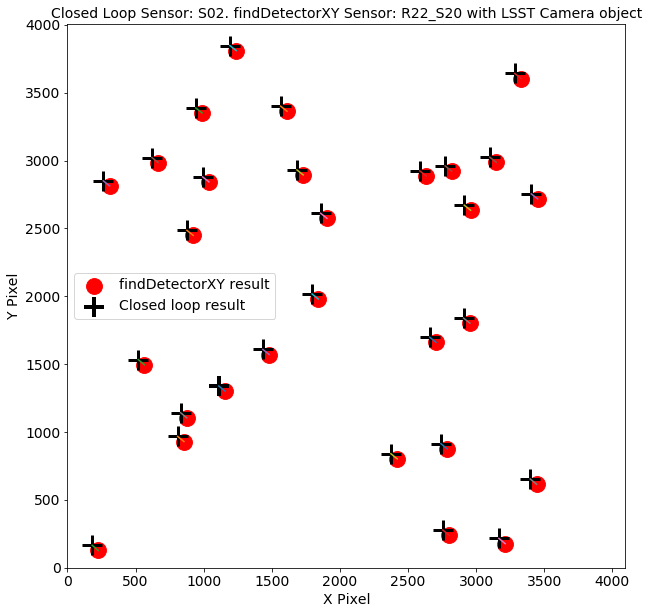

In [38]:
fig = plt.figure(figsize=(10,10))
sensor_name = "S02"
sensor_df = df.query('sensor == "%s"' % sensor_name)
legend_set = False
for row_idx, test_obj in sensor_df.iterrows():
    detector, point_xy = findDetectorAndXY(test_obj['ra'], test_obj['dec'], tel_rot*lsst.geom.degrees, boresight_pointing, lsst_camera, flipX=True)
    if legend_set is False:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250, label='findDetectorXY result')
        plt.scatter(test_obj['y_center'], test_obj['x_center'], c='k', marker='+', lw=4, s=400, label='Closed loop result')
        legend_set = True
    else:
        plt.scatter(point_xy[0], point_xy[1], c='r', s=250)
        plt.scatter(test_obj['y_center'], test_obj['x_center'], c='k', s=400, marker='+', lw=3, )
    plt.plot([point_xy[0], test_obj['y_center']], [point_xy[1], test_obj['x_center']])
plt.xlim(0, 4096)
plt.ylim(0, 4004)
plt.xlabel('X Pixel', size=14)
plt.ylabel('Y Pixel', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Closed Loop Sensor: {}. findDetectorXY Sensor: {} with LSST Camera object'.format(sensor_name, detector.getName()), size=14)
plt.legend(fontsize=14)